In [1]:
!unzip ../input/forest-cover-type-kernels-only/train.csv.zip -d /kaggle/working
!unzip ../input/forest-cover-type-kernels-only/test.csv.zip -d /kaggle/working
!unzip ../input/forest-cover-type-kernels-only/sample_submission.csv.zip -d /kaggle/working

Archive:  ../input/forest-cover-type-kernels-only/train.csv.zip
  inflating: /kaggle/working/train.csv  
Archive:  ../input/forest-cover-type-kernels-only/test.csv.zip
  inflating: /kaggle/working/test.csv  
Archive:  ../input/forest-cover-type-kernels-only/sample_submission.csv.zip
  inflating: /kaggle/working/sample_submission.csv  


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD
from sklearn import datasets
from sklearn.model_selection import train_test_split



import os
import gc
from itertools import combinations, chain
from datetime import datetime

Using TensorFlow backend.


In [3]:
import lightgbm as lgb

from tqdm import tqdm

# summary

## model summary
We created a total of 10 learning models and stacked their predicted by LightGBM.

table of contents



# nadare's kernel

In [4]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
smpsb = pd.read_csv("./sample_submission.csv")

## preprocessing

### EDA & leader board hacking

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


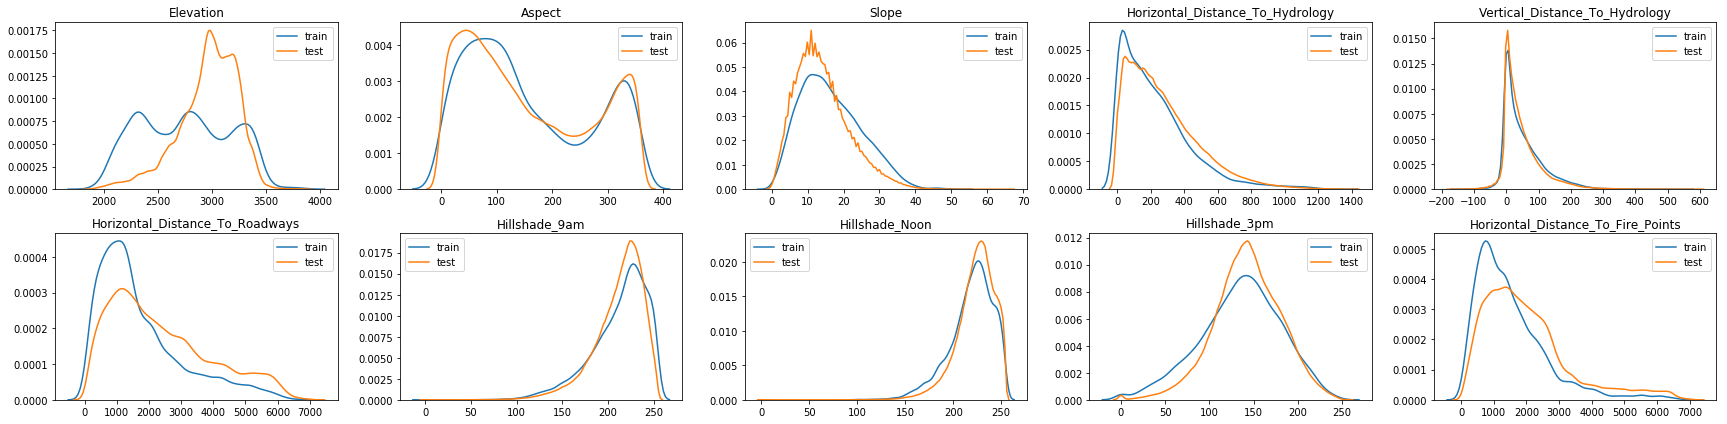

In [5]:
# First of all, let's see the distribution of each variable.
# You can see that there is a big difference in distribution between training data and test data.

from scipy.stats import gaussian_kde

def compare_dist(ax, feature, i=0):
    sns.kdeplot(train_df[feature], label="train", ax=ax)
    sns.kdeplot(test_df[feature], label="test", ax=ax)


def numeric_tile(plot_func):
    fig, axs = plt.subplots(2, 5, figsize=(24, 6))
    axs = axs.flatten()
    
    for i, (ax, col) in enumerate(zip(axs, train_df.columns.tolist()[1:11])):
        plot_func(ax, col, i)
        ax.set_title(col)
    plt.tight_layout()
    
numeric_tile(compare_dist)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


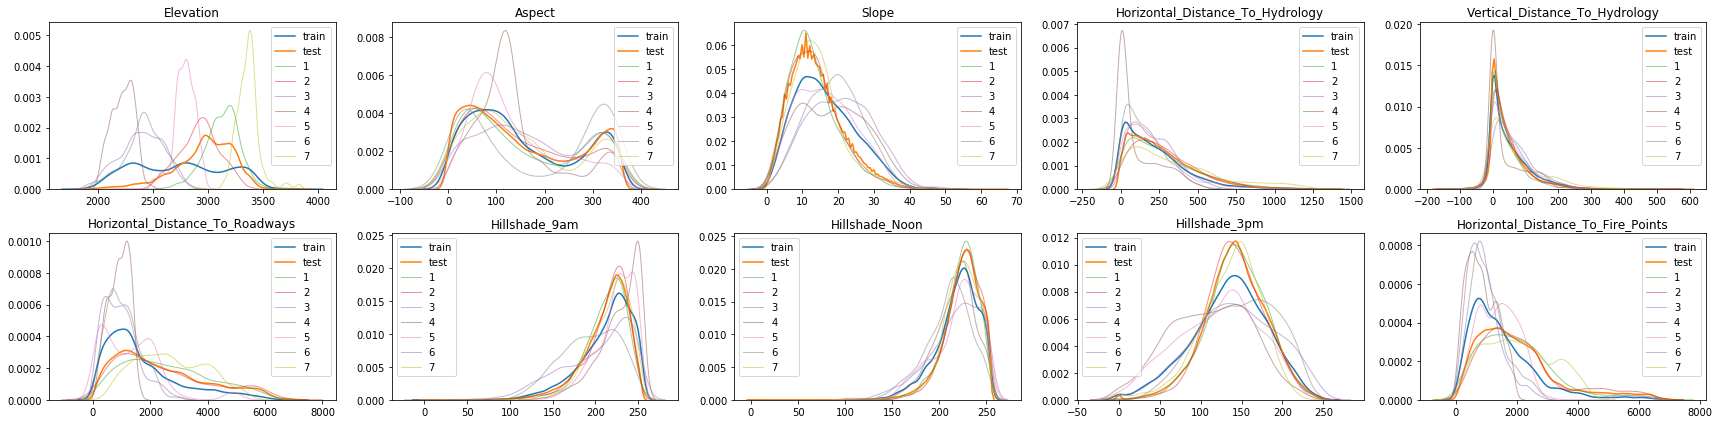

In [6]:
# For the training data, display the distribution of variables for each target.

# Please pay attention to "Elevation". The difference between the training data and the test data distribution is
# thought to be due to the difference between the proportion of the target variables in the training data and the test data.

def compare_target(ax, feature, i=0):
    sns.kdeplot(train_df.loc[:, feature], label="train", ax=ax)
    sns.kdeplot(test_df.loc[:, feature], label="test", ax=ax)
    for target in range(1, 8):
        sns.kdeplot(train_df.loc[train_df["Cover_Type"] == target, feature], label=target, alpha=0.5, lw=1, ax=ax)

numeric_tile(compare_target)        

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


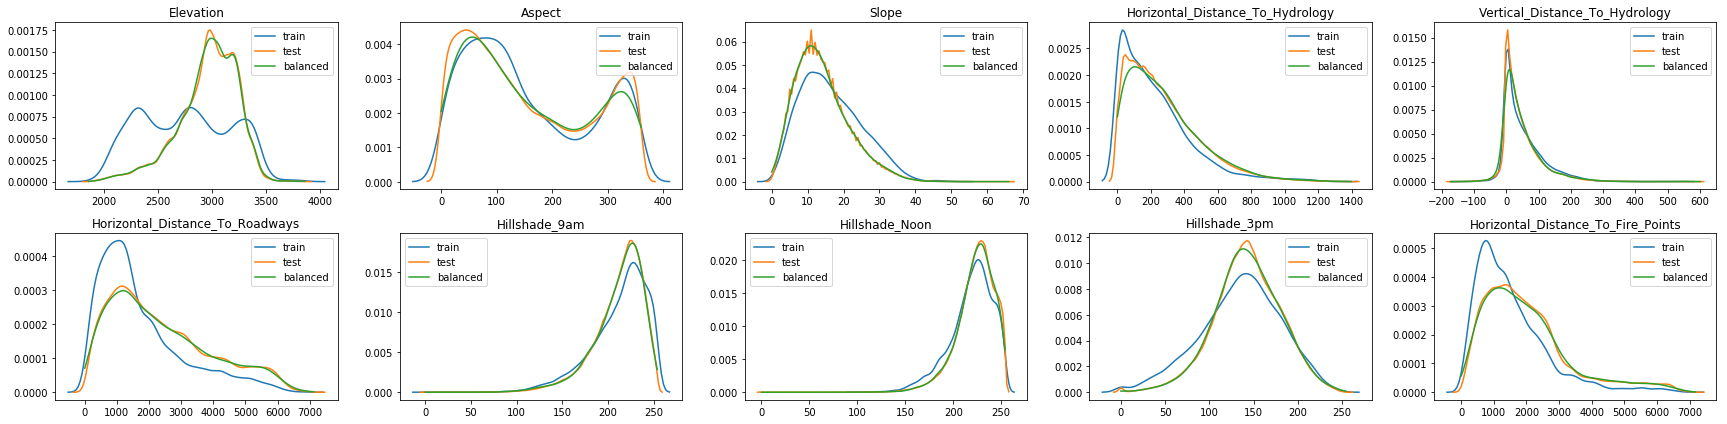

In [7]:
# I was able to obtain the distribution of the test data by submitting prediction data with all the same purpose variables.

"""
smpsb = pd.read_csv("./sample_submission.csv")
for i in range(1, 8):
    smpsb["Cover_Type"] = i
    smpsb.to_csv("all_{}.csv".format(i), index=None)"""

# and this is the magic number of this competition.
type_ratio = np.array([0.37053, 0.49681, 0.05936, 0.00103, 0.01295, 0.02687, 0.03242])
class_weight = {k: v for k, v in enumerate(type_ratio, start=1)}

# By using these numbers, you can mimic the distribution of the test data from the training data.
def compare_balanced_dist(ax, feature, i=0):
    min_ = min(train_df[feature].min(), test_df[feature].min())
    max_ = max(train_df[feature].max(), test_df[feature].max())
    X = np.linspace(min_, max_, 1000)

    sns.kdeplot(train_df[feature], label="train", ax=ax)
    sns.kdeplot(test_df[feature], label="test", ax=ax)
    btest = np.zeros(1000)
    
    for target in range(1, 8):
        btest += gaussian_kde(train_df.loc[train_df["Cover_Type"] == target, feature])(X) * type_ratio[target-1]
    
    ax.plot(X, btest, label="balanced")
    ax.legend()

numeric_tile(compare_balanced_dist)

In [8]:
# By using the following functions, it is possible to perform almost the same evaluation
# as the leader board even in the local environment.

def balanced_accuracy_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred, sample_weight=np.apply_along_axis(lambda x: type_ratio[x], 0, y_true-1))


### feature engineering 1

I will explain some of the features I consider important or unique.

#### Aspect

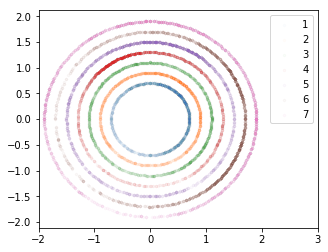

In [9]:
# The angle can be divided into sine and cosine
sin_ = np.sin(np.pi*train_df["Aspect"]/180)
cos_ = np.cos(np.pi*train_df["Aspect"]/180)

# However, if this feature quantity alone, the effect seems to be light.
plt.figure(figsize=(5, 4))
for i in range(1, 8):
    cat = np.where(train_df["Cover_Type"] == i)[0]
    r = (.5+0.2*i)
    plt.scatter(cos_[cat]*(r), sin_[cat]*(r), alpha=0.02*r, s=6, label=i)
plt.xlim(-2, 3)
plt.legend()
plt.savefig("aspect.png")

#### degree to hydrology

In [10]:
# this may be good feature but unfortunally i forgot to add my data
hydro_h = train_df["Vertical_Distance_To_Hydrology"]
hydro_v = train_df["Horizontal_Distance_To_Hydrology"]

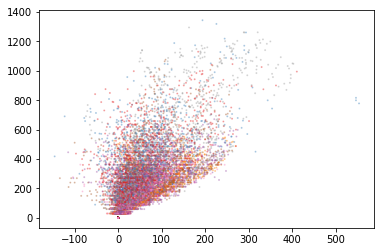

In [11]:
plt.scatter(hydro_h, hydro_v, s=1, c=train_df["Cover_Type"], cmap="Set1", alpha=0.3)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


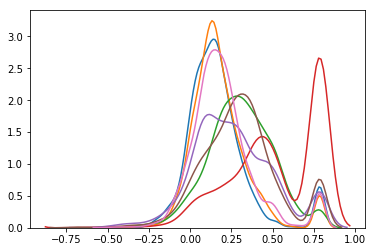

In [12]:
hydro_arctan = np.arctan((hydro_h+0.0001) / (hydro_v+0.0001))
for i in range(1, 8):
    cat = np.where(train_df["Cover_Type"] == i)[0]
    sns.kdeplot(hydro_arctan[cat])

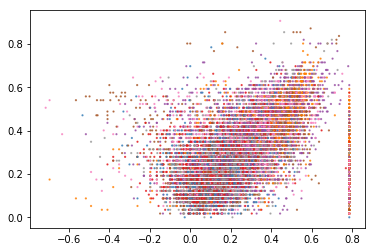

In [13]:
plt.scatter(hydro_arctan, np.pi*train_df["Slope"]/180, c=train_df["Cover_Type"], cmap="Set1", s=1.5, alpha=0.7)

#### target_encoding 

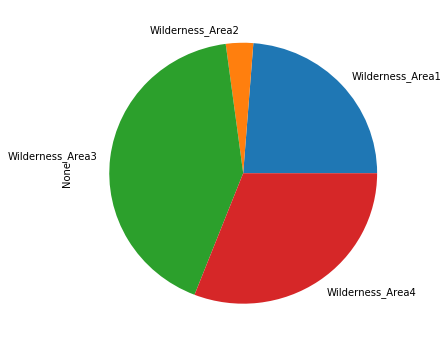

In [14]:
# this is the ratio of Wilderness_Area
plt.figure(figsize=(6, 6))
train_df.filter(regex="Wilder").sum(axis=0).plot("pie")

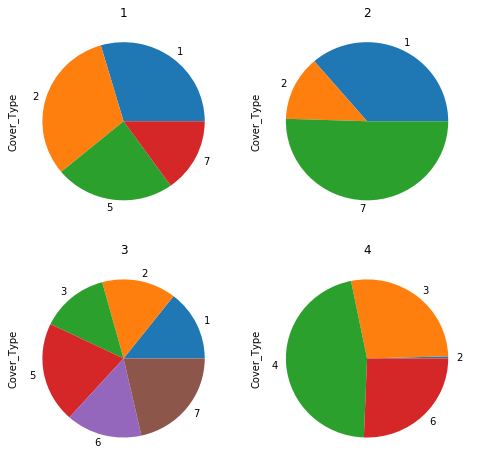

In [15]:
# and this is ratio of "over_Type" in each "Wildereness_area"
wilder = (train_df.filter(regex="Wilder") * np.array([1, 2, 3, 4])).sum(axis=1)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for i, ax in enumerate(axs, start=1):
    train_df.loc[wilder==i, "Cover_Type"].value_counts().sort_index().plot("pie", ax=ax)
    ax.set_title(i)

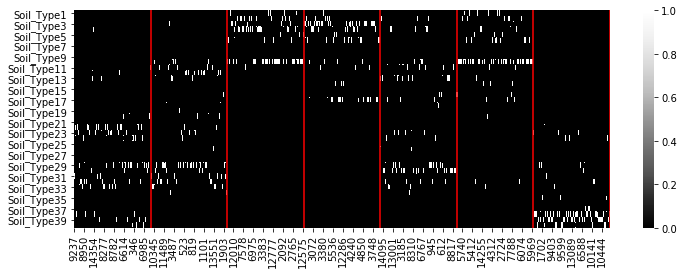

In [16]:
# This shows the expression of Soil_Type for the objective variable.
plt.figure(figsize=(12, 4))
sns.heatmap(train_df.iloc[:, -41:].sort_values(by="Cover_Type").iloc[:, :-1].T, cmap="Greys_r")
for i in np.linspace(0, train_df.shape[0], 8)[1:]:
    plt.axvline(i, c="r")

As indicated above, category values are considered to have a major role in classification.

Therefore, in order to handle category values effectively, the ratio of object variables in each category value is added as a feature quantity.

In order to prevent data leakage and not to excessively trust category values which have only a small number, we added values for 10 data as prior distribution to each category.

In [17]:
# this is the code
def categorical_post_mean(x):
    p = (x.values)*type_ratio
    p = p/p.sum()*x.sum() + 10*type_ratio
    return p/p.sum()

#### summarizes preprocessing

In [18]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
smpsb = pd.read_csv("./sample_submission.csv")

def main(train_df, test_df):
    # this is public leaderboard ratio
    start = datetime.now()
    type_ratio = np.array([0.37053, 0.49681, 0.05936, 0.00103, 0.01295, 0.02687, 0.03242])
    
    total_df = pd.concat([train_df.iloc[:, :-1], test_df])
    
    # Aspect
    total_df["Aspect_Sin"] = np.sin(np.pi*total_df["Aspect"]/180)
    total_df["Aspect_Cos"] = np.cos(np.pi*total_df["Aspect"]/180)
    print("Aspect", (datetime.now() - start).seconds)
    
    # Hillshade
    hillshade_col = ["Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm"]
    for col1, col2 in combinations(hillshade_col, 2):
        total_df[col1 + "_add_" + col2] = total_df[col2] + total_df[col1]
        total_df[col1 + "_dif_" + col2] = total_df[col2] - total_df[col1]
        total_df[col1 + "_div_" + col2] = (total_df[col2]+0.01) / (total_df[col1]+0.01)
        total_df[col1 + "_abs_" + col2] = np.abs(total_df[col2] - total_df[col1])
    
    total_df["Hillshade_mean"] = total_df[hillshade_col].mean(axis=1)
    total_df["Hillshade_std"] = total_df[hillshade_col].std(axis=1)
    total_df["Hillshade_max"] = total_df[hillshade_col].max(axis=1)
    total_df["Hillshade_min"] = total_df[hillshade_col].min(axis=1)
    print("Hillshade", (datetime.now() - start).seconds)
    
    # Hydrology ** I forgot to add arctan
    total_df["Degree_to_Hydrology"] = ((total_df["Vertical_Distance_To_Hydrology"] + 0.001) /
                                       (total_df["Horizontal_Distance_To_Hydrology"] + 0.01))
    
    # Holizontal
    horizontal_col = ["Horizontal_Distance_To_Hydrology",
                      "Horizontal_Distance_To_Roadways",
                      "Horizontal_Distance_To_Fire_Points"]
    
    
    for col1, col2 in combinations(hillshade_col, 2):
        total_df[col1 + "_add_" + col2] = total_df[col2] + total_df[col1]
        total_df[col1 + "_dif_" + col2] = total_df[col2] - total_df[col1]
        total_df[col1 + "_div_" + col2] = (total_df[col2]+0.01) / (total_df[col1]+0.01)
        total_df[col1 + "_abs_" + col2] = np.abs(total_df[col2] - total_df[col1])
    print("Holizontal", (datetime.now() - start).seconds)
    
    
    def categorical_post_mean(x):
        p = (x.values)*type_ratio
        p = p/p.sum()*x.sum() + 10*type_ratio
        return p/p.sum()
    
    # Wilder
    wilder = pd.DataFrame([(train_df.iloc[:, 11:15] * np.arange(1, 5)).sum(axis=1),
                          train_df.Cover_Type]).T
    wilder.columns = ["Wilder_Type", "Cover_Type"]
    wilder["one"] = 1
    piv = wilder.pivot_table(values="one",
                             index="Wilder_Type",
                             columns="Cover_Type",
                             aggfunc="sum").fillna(0)
    
    tmp = pd.DataFrame(piv.apply(categorical_post_mean, axis=1).tolist()).reset_index()
    tmp["index"] = piv.sum(axis=1).index
    tmp.columns = ["Wilder_Type"] + ["Wilder_prob_ctype_{}".format(i) for i in range(1, 8)]
    tmp["Wilder_Type_count"] = piv.sum(axis=1).values
    
    total_df["Wilder_Type"] = (total_df.filter(regex="Wilder") * np.arange(1, 5)).sum(axis=1)
    total_df = total_df.merge(tmp, on="Wilder_Type", how="left")
    
    for i in range(7):
        total_df.loc[:, "Wilder_prob_ctype_{}".format(i+1)] = total_df.loc[:, "Wilder_prob_ctype_{}".format(i+1)].fillna(type_ratio[i])
    total_df.loc[:, "Wilder_Type_count"] = total_df.loc[:, "Wilder_Type_count"].fillna(0)
    print("Wilder_type", (datetime.now() - start).seconds)
    
    
    # Soil type
    soil = pd.DataFrame([(train_df.iloc[:, -41:-1] * np.arange(1, 41)).sum(axis=1),
                          train_df.Cover_Type]).T
    soil.columns = ["Soil_Type", "Cover_Type"]
    soil["one"] = 1
    piv = soil.pivot_table(values="one",
                           index="Soil_Type",
                           columns="Cover_Type",
                           aggfunc="sum").fillna(0)
    
    tmp = pd.DataFrame(piv.apply(categorical_post_mean, axis=1).tolist()).reset_index()
    tmp["index"] = piv.sum(axis=1).index
    tmp.columns = ["Soil_Type"] + ["Soil_prob_ctype_{}".format(i) for i in range(1, 8)]
    tmp["Soil_Type_count"] = piv.sum(axis=1).values
    
    total_df["Soil_Type"] = (total_df.filter(regex="Soil") * np.arange(1, 41)).sum(axis=1)
    total_df = total_df.merge(tmp, on="Soil_Type", how="left")
    
    for i in range(7):
        total_df.loc[:, "Soil_prob_ctype_{}".format(i+1)] = total_df.loc[:, "Soil_prob_ctype_{}".format(i+1)].fillna(type_ratio[i])
    total_df.loc[:, "Soil_Type_count"] = total_df.loc[:, "Soil_Type_count"].fillna(0)
    print("Soil_type", (datetime.now() - start).seconds)
    
    icol = total_df.select_dtypes(np.int64).columns
    fcol = total_df.select_dtypes(np.float64).columns
    total_df.loc[:, icol] = total_df.loc[:, icol].astype(np.int32)
    total_df.loc[:, fcol] = total_df.loc[:, fcol].astype(np.float32)
    return total_df

total_df = main(train_df, test_df)
one_col = total_df.filter(regex="(Type\d+)|(Area\d+)").columns
total_df = total_df.drop(one_col, axis=1)

Aspect 0
Hillshade 1
Holizontal 1
Wilder_type 5
Soil_type 9


In [19]:
y = train_df["Cover_Type"].values
X = total_df[total_df["Id"] <= 15120].drop("Id", axis=1)
X_test = total_df[total_df["Id"] > 15120].drop("Id", axis=1)

In [20]:
gc.collect()

56

### KNN features and Decision tree feature

For the variable created up to the above, the decision tree and the k-nearest neighbor method are applied after narrowing down the number of variables and adding the prediction probability as the feature amount. 

I decided the combination of variables to be used last and the setting of parameters based on Multi-class logarithmic loss while considering diversity.

#### KNN_feature

In [21]:
all_set =  [['Elevation', 500],
            ['Horizontal_Distance_To_Roadways', 500],
            ['Horizontal_Distance_To_Fire_Points', 500],
            ['Horizontal_Distance_To_Hydrology', 500],
            ['Hillshade_9am', 500],
            ['Aspect', 500],
            ['Hillshade_3pm', 500],
            ['Slope', 500],
            ['Hillshade_Noon', 500],
            ['Vertical_Distance_To_Hydrology', 500],
            ['Elevation_PLUS_Vertical_Distance_To_Hydrology', 200],
            ['Elevation_PLUS_Hillshade_9am_add_Hillshade_Noon', 200],
            ['Elevation_PLUS_Aspect', 200],
            ['Elevation_PLUS_Hillshade_Noon_dif_Hillshade_3pm', 200],
            ['Elevation_PLUS_Hillshade_Noon_abs_Hillshade_3pm', 200],
            ['Elevation_PLUS_Hillshade_9am', 200],
            ['Elevation_PLUS_Horizontal_Distance_To_Hydrology', 200],
            ['Elevation_PLUS_Horizontal_Distance_To_Roadways', 100],
            ['Elevation_PLUS_Vertical_Distance_To_Hydrology', 200],
            ['Wilder_Type_PLUS_Elevation', 500],
            ['Wilder_Type_PLUS_Hillshade_Noon_div_Hillshade_3pm', 500],
            ['Wilder_Type_PLUS_Degree_to_Hydrology', 200],
            ['Wilder_Type_PLUS_Hillshade_9am_div_Hillshade_3pm', 500],
            ['Wilder_Type_PLUS_Aspect_Cos', 500],
            ['Hillshade_9am_dif_Hillshade_Noon_PLUS_Hillshade_Noon_dif_Hillshade_3pm', 200],
            ['Hillshade_Noon_PLUS_Hillshade_3pm', 200],
            ['Hillshade_Noon_add_Hillshade_3pm_PLUS_Hillshade_Noon_dif_Hillshade_3pm', 200]]


def simple_feature_scores2(clf, cols, test=False, **params):
    scores = []
    bscores = []
    lscores = []
    
    X_preds = np.zeros((len(y), 7))
    scl = StandardScaler().fit(X.loc[:, cols])
    
    for train, val in StratifiedKFold(n_splits=10, shuffle=True, random_state=2018).split(X, y):
        X_train = scl.transform(X.loc[train, cols])
        X_val = scl.transform(X.loc[val, cols])
        y_train = y[train]
        y_val = y[val]
        C = clf(**params) 

        C.fit(X_train, y_train)
        X_preds[val] = C.predict_proba(X_val)
        #scores.append(accuracy_score(y_val, C.predict(X_val)))
        #bscores.append(balanced_accuracy_score(y_val, C.predict(X_val)))
        #lscores.append(log_loss(y_val, C.predict_proba(X_val), labels=list(range(1, 8))))
    
    if test:
        X_test_select = scl.transform(X_test.loc[:, cols])
        C = clf(**params)
        C.fit(scl.transform(X.loc[:, cols]), y)
        X_test_preds = C.predict_proba(X_test_select)
    else:
        X_test_preds = None
    return scores, bscores, lscores, X_preds, X_test_preds

In [22]:
import warnings
import gc
from multiprocessing import Pool

warnings.filterwarnings("ignore")

preds = []
test_preds = []
for colname, neighbor in tqdm(all_set):
    gc.collect()
    #print(colname, depth)
    ts, tbs, ls, pred, test_pred = simple_feature_scores2(KNeighborsClassifier,
                                                          colname.split("_PLUS_"),
                                                          test=True,
                                                          n_neighbors=neighbor)
    preds.append(pred)
    test_preds.append(test_pred)

100%|██████████| 27/27 [44:44<00:00, 99.44s/it] 


In [23]:
cols = list(chain.from_iterable([[col[0] + "_KNN_{}".format(i) for i in range(1, 8)] for col in all_set]))
knn_train_df = pd.DataFrame(np.hstack(preds)).astype(np.float32)
knn_train_df.columns = cols
knn_test_df = pd.DataFrame(np.hstack(test_preds)).astype(np.float32)
knn_test_df.columns = cols


#### DT_features

In [24]:
all_set = [['Elevation', 4],
           ['Horizontal_Distance_To_Roadways', 4],
           ['Horizontal_Distance_To_Fire_Points', 3],
           ['Horizontal_Distance_To_Hydrology', 4],
           ['Hillshade_9am', 3],
           ['Vertical_Distance_To_Hydrology', 3],
           ['Slope', 4],
           ['Aspect', 4],
           ['Hillshade_3pm', 3],
           ['Hillshade_Noon', 3],
           ['Degree_to_Hydrology', 3],
           ['Hillshade_Noon_dif_Hillshade_3pm', 3],
           ['Hillshade_Noon_abs_Hillshade_3pm', 3],
           ['Elevation_PLUS_Hillshade_9am_add_Hillshade_Noon', 5],
           ['Elevation_PLUS_Hillshade_max', 5],
           ['Elevation_PLUS_Horizontal_Distance_To_Hydrology', 5],
           ['Aspect_Sin_PLUS_Aspect_Cos_PLUS_Elevation', 5],
           ['Elevation_PLUS_Horizontal_Distance_To_Fire_Points', 5],
           ['Wilder_Type_PLUS_Elevation', 5],
           ['Elevation_PLUS_Hillshade_9am', 5],
           ['Elevation_PLUS_Degree_to_Hydrology', 5],
           ['Wilder_Type_PLUS_Horizontal_Distance_To_Roadways', 5],
           ['Wilder_Type_PLUS_Hillshade_9am_add_Hillshade_Noon', 4],
           ['Wilder_Type_PLUS_Horizontal_Distance_To_Hydrology', 5],
           ['Wilder_Type_PLUS_Hillshade_Noon_abs_Hillshade_3pm', 4],
           ['Hillshade_9am_add_Hillshade_Noon_PLUS_Hillshade_std', 4],
           ['Hillshade_9am_PLUS_Hillshade_9am_add_Hillshade_Noon', 4],
           ['Hillshade_9am_add_Hillshade_Noon_PLUS_Hillshade_Noon_add_Hillshade_3pm', 5]]

def simple_feature_scores(clf, cols, test=False, **params):
    scores = []
    bscores = []
    lscores = []
    
    X_preds = np.zeros((len(y), 7))
    
    
    for train, val in StratifiedKFold(n_splits=10, shuffle=True, random_state=2018).split(X, y):
        X_train = X.loc[train, cols]
        X_val = X.loc[val, cols]
        y_train = y[train]
        y_val = y[val]
        C = clf(**params) 

        C.fit(X_train, y_train)
        X_preds[val] = C.predict_proba(X_val)
        #scores.append(accuracy_score(y_val, C.predict(X_val)))
        #bscores.append(balanced_accuracy_score(y_val, C.predict(X_val)))
        #lscores.append(log_loss(y_val, C.predict_proba(X_val), labels=list(range(1, 8))))
    
    if test:
        X_test_select = X_test.loc[:, cols]
        C = clf(**params)
        C.fit(X.loc[:, cols], y)
        X_test_preds = C.predict_proba(X_test_select)
    else:
        X_test_preds = None
    return scores, bscores, lscores, X_preds, X_test_preds

In [25]:
preds = []
test_preds = []
for colname, depth in tqdm(all_set):
    #print(colname, depth)
    ts, tbs, ls, pred, test_pred = simple_feature_scores(DecisionTreeClassifier,
                                                         colname.split("_PLUS_"),
                                                         test=True,
                                                         max_depth=depth)
    preds.append(pred)
    test_preds.append(test_pred)

cols = list(chain.from_iterable([[col[0] + "_DT_{}".format(i) for i in range(1, 8)] for col in all_set]))
dt_train_df = pd.DataFrame(np.hstack(preds)).astype(np.float32)
dt_train_df.columns = cols

dt_test_df = pd.DataFrame(np.hstack(test_preds)).astype(np.float32)
dt_test_df.columns = cols

100%|██████████| 28/28 [00:05<00:00,  4.72it/s]


In [26]:
# target encoding features(1.2.3)
te_train_df = total_df.filter(regex="ctype").iloc[:len(train_df)]
te_test_df = total_df.filter(regex="ctype").iloc[len(train_df):]


In [27]:
train_level2 = train_df[["Id"]]
test_level2 = test_df[["Id"]]

## modeling

I have created 6 models

without KNN&DT features
* Random Forest Classifier
* PCA & K-nearest Neighbors Classifier
* LightGBM

with KNN & DT features
* Random Forest Classifier
* Logistic Regression
* LightGBM

Using these learning machines, data for stacking was created using 10-fold cross validation.

### without KNN&DT feature

In [28]:
y = train_df["Cover_Type"].values
X = total_df[total_df["Id"] <= 15120].drop("Id", axis=1)
X_test = total_df[total_df["Id"] > 15120].drop("Id", axis=1)
type_ratio = np.array([0.37053, 0.49681, 0.05936, 0.00103, 0.01295, 0.02687, 0.03242])
class_weight = {k: v for k, v in enumerate(type_ratio, start=1)}

#### Random forest classifier

In [29]:
RFC1_col = ["RFC1_{}_proba".format(i) for i in range(1, 8)]
for col in RFC1_col:
    train_level2.loc[:, col] = 0
    test_level2.loc[:, col] = 0

In [30]:
rfc = RandomForestClassifier(n_estimators=150,
                             max_depth=12,
                             class_weight=class_weight,
                             n_jobs=-1)

confusion = np.zeros((7, 7))
scores = []
for train, val in tqdm(StratifiedKFold(n_splits=10, random_state=2434, shuffle=True).split(X, y)):
    X_train = X.iloc[train, :]
    X_val = X.iloc[val, :]

    y_train = y[train]
    y_val = y[val]
    rfc.fit(X_train, y_train)
    y_val_pred = rfc.predict(X_val)
    y_val_proba = rfc.predict_proba(X_val)
    
    confusion += confusion_matrix(y_val, y_val_pred)    
    train_level2.loc[val, RFC1_col] = y_val_proba
    scores.append(balanced_accuracy_score(y_val, y_val_pred))

rfc.fit(X, y)
test_level2.loc[:, RFC1_col] = rfc.predict_proba(X_test)
#smpsb.loc[:, "Cover_Type"] = rfc.predict(X_test)
#smpsb.to_csv("RFC1.csv", index=None)

10it [00:28,  2.84s/it]


0.7500738864758536


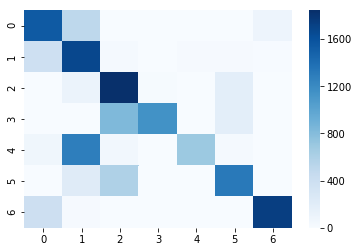

In [31]:
print(np.mean(scores))
sns.heatmap(confusion, cmap="Blues")

#### PCA & KNN

In [32]:
KNN1_col = ["KNN1_{}_proba".format(i) for i in range(1, 8)]
for col in KNN1_col:
    train_level2.loc[:, col] = 0
    test_level2.loc[:, col] = 0

In [33]:
cat_col = X.filter(regex="Soil_Type|Wilderness").columns.tolist()[:-1] + ["Wilder_Type"]

In [34]:
knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)

scl = StandardScaler().fit(X_test.drop(cat_col, axis=1))
X_scl = scl.transform(X.drop(cat_col, axis=1))
X_test_scl = scl.transform(X_test.drop(cat_col, axis=1))
pca = PCA(n_components=23).fit(X_test_scl)
X_pca = pca.transform(X_scl)
X_test_pca = pca.transform(X_test_scl)

confusion = np.zeros((7, 7))
scores = []
for train, val in tqdm(StratifiedKFold(n_splits=10, random_state=2434, shuffle=True).split(X, y)):
    X_train = X_pca[train]
    X_val = X_pca[val]

    y_train = y[train]
    y_val = y[val]
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_val)
    y_val_proba = knn.predict_proba(X_val)
    
    confusion += confusion_matrix(y_val, y_val_pred)    
    train_level2.loc[val, KNN1_col] = y_val_proba
    scores.append(balanced_accuracy_score(y_val, y_val_pred))

knn.fit(X_pca, y)
test_level2.loc[:, KNN1_col] = knn.predict_proba(X_test_pca)
#smpsb.loc[:, "Cover_Type"] = knn.predict(X_test_pca)
#smpsb.to_csv("KNN1.csv", index=None)

10it [00:08,  1.15it/s]


0.6390144852493723


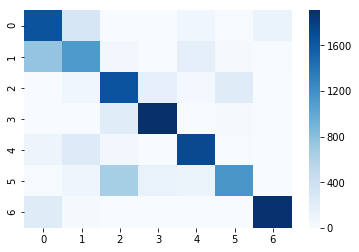

In [35]:
print(np.mean(scores))
sns.heatmap(confusion, cmap="Blues")

#### LightGBM

In [36]:
LGBM1_col = ["LGBM1_{}_proba".format(i) for i in range(1, 8)]
for col in LGBM1_col:
    train_level2.loc[:, col] = 0
    test_level2.loc[:, col] = 0

In [37]:
cat_col = X.filter(regex="Soil_Type|Wilderness").columns.tolist()[:-1] + ["Wilder_Type"]
categorical_feature = [29, 38]
lgbm_col = X.drop(cat_col[:-2], axis=1).columns.tolist()
class_weight_lgbm = {i: v for i, v in enumerate(type_ratio)}

In [38]:
gbm = lgb.LGBMClassifier(n_estimators=15,
                         num_class=7,
                         learning_rate=0.1,
                         bagging_fraction=0.6,
                         num_boost_round=370,
                         max_depth=8,
                         max_cat_to_onehot=40,
                         class_weight=class_weight_lgbm,
                         device="cpu",
                         n_jobs=4,
                         silent=-1,
                         verbose=-1)

confusion = np.zeros((7, 7))
scores = []
for train, val in tqdm(StratifiedKFold(n_splits=10, random_state=2434, shuffle=True).split(X, y)):
    X_train = X.loc[train, lgbm_col]
    X_val = X.loc[val, lgbm_col]

    y_train = y[train]
    y_val = y[val]
    gbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=50, categorical_feature=categorical_feature)

    y_val_pred = gbm.predict(X_val)
    y_val_proba = gbm.predict_proba(X_val)
    
    scores.append(balanced_accuracy_score(y_val, y_val_pred))
    confusion += confusion_matrix(y_val, y_val_pred)
    train_level2.loc[val, LGBM1_col] = y_val_proba


X_all = X.loc[:, lgbm_col]
X_test_lgbm = X_test.loc[:, lgbm_col]
gbm.fit(X_all, y, verbose=50, categorical_feature=categorical_feature)
test_level2.loc[:, LGBM1_col] = gbm.predict_proba(X_test_lgbm)
#smpsb["Cover_Type"] = gbm.predict(X_test_lgbm)
#smpsb.to_csv("LGBM1.csv")

0it [00:00, ?it/s]

[50]	training's multi_logloss: 0.360484	valid_1's multi_logloss: 0.72782
[100]	training's multi_logloss: 0.243012	valid_1's multi_logloss: 0.561693
[150]	training's multi_logloss: 0.174366	valid_1's multi_logloss: 0.486636
[200]	training's multi_logloss: 0.126042	valid_1's multi_logloss: 0.444298
[250]	training's multi_logloss: 0.0899132	valid_1's multi_logloss: 0.425964
[300]	training's multi_logloss: 0.0637977	valid_1's multi_logloss: 0.41643
[350]	training's multi_logloss: 0.0461794	valid_1's multi_logloss: 0.416004


1it [00:11, 11.54s/it]

[50]	training's multi_logloss: 0.365599	valid_1's multi_logloss: 0.722763
[100]	training's multi_logloss: 0.246902	valid_1's multi_logloss: 0.567404
[150]	training's multi_logloss: 0.17808	valid_1's multi_logloss: 0.501509
[200]	training's multi_logloss: 0.127687	valid_1's multi_logloss: 0.458539
[250]	training's multi_logloss: 0.0911562	valid_1's multi_logloss: 0.433717
[300]	training's multi_logloss: 0.0654405	valid_1's multi_logloss: 0.415677
[350]	training's multi_logloss: 0.0468605	valid_1's multi_logloss: 0.404473


2it [00:33, 17.00s/it]

[50]	training's multi_logloss: 0.370405	valid_1's multi_logloss: 0.726339
[100]	training's multi_logloss: 0.252283	valid_1's multi_logloss: 0.567607
[150]	training's multi_logloss: 0.175252	valid_1's multi_logloss: 0.484962
[200]	training's multi_logloss: 0.12404	valid_1's multi_logloss: 0.442092
[250]	training's multi_logloss: 0.0895097	valid_1's multi_logloss: 0.41651
[300]	training's multi_logloss: 0.0629081	valid_1's multi_logloss: 0.402546
[350]	training's multi_logloss: 0.0460626	valid_1's multi_logloss: 0.398462


3it [00:45, 15.20s/it]

[50]	training's multi_logloss: 0.365351	valid_1's multi_logloss: 0.709084
[100]	training's multi_logloss: 0.243038	valid_1's multi_logloss: 0.546565
[150]	training's multi_logloss: 0.173323	valid_1's multi_logloss: 0.475508
[200]	training's multi_logloss: 0.12566	valid_1's multi_logloss: 0.430653
[250]	training's multi_logloss: 0.0913466	valid_1's multi_logloss: 0.403786
[300]	training's multi_logloss: 0.0654679	valid_1's multi_logloss: 0.387322
[350]	training's multi_logloss: 0.0468639	valid_1's multi_logloss: 0.377029


4it [00:59, 14.85s/it]

[50]	training's multi_logloss: 0.366089	valid_1's multi_logloss: 0.714456
[100]	training's multi_logloss: 0.254095	valid_1's multi_logloss: 0.565473
[150]	training's multi_logloss: 0.183424	valid_1's multi_logloss: 0.493082
[200]	training's multi_logloss: 0.131744	valid_1's multi_logloss: 0.454617
[250]	training's multi_logloss: 0.094033	valid_1's multi_logloss: 0.429593
[300]	training's multi_logloss: 0.0665476	valid_1's multi_logloss: 0.413241
[350]	training's multi_logloss: 0.04802	valid_1's multi_logloss: 0.405734


5it [01:10, 14.18s/it]

[50]	training's multi_logloss: 0.363482	valid_1's multi_logloss: 0.745517
[100]	training's multi_logloss: 0.243324	valid_1's multi_logloss: 0.580031
[150]	training's multi_logloss: 0.177071	valid_1's multi_logloss: 0.504661
[200]	training's multi_logloss: 0.125225	valid_1's multi_logloss: 0.459833
[250]	training's multi_logloss: 0.0898246	valid_1's multi_logloss: 0.433173
[300]	training's multi_logloss: 0.064048	valid_1's multi_logloss: 0.416179
[350]	training's multi_logloss: 0.0462739	valid_1's multi_logloss: 0.411438


6it [01:22, 13.78s/it]

[50]	training's multi_logloss: 0.362995	valid_1's multi_logloss: 0.744778
[100]	training's multi_logloss: 0.242818	valid_1's multi_logloss: 0.578149
[150]	training's multi_logloss: 0.17307	valid_1's multi_logloss: 0.505052
[200]	training's multi_logloss: 0.12155	valid_1's multi_logloss: 0.459859
[250]	training's multi_logloss: 0.086641	valid_1's multi_logloss: 0.436197
[300]	training's multi_logloss: 0.0624622	valid_1's multi_logloss: 0.422731
[350]	training's multi_logloss: 0.043921	valid_1's multi_logloss: 0.416772


7it [01:34, 13.45s/it]

[50]	training's multi_logloss: 0.364048	valid_1's multi_logloss: 0.748673
[100]	training's multi_logloss: 0.248591	valid_1's multi_logloss: 0.592785
[150]	training's multi_logloss: 0.175049	valid_1's multi_logloss: 0.519477
[200]	training's multi_logloss: 0.121648	valid_1's multi_logloss: 0.468747
[250]	training's multi_logloss: 0.0881285	valid_1's multi_logloss: 0.442492
[300]	training's multi_logloss: 0.0625096	valid_1's multi_logloss: 0.424166
[350]	training's multi_logloss: 0.0436298	valid_1's multi_logloss: 0.411725


8it [01:45, 13.22s/it]

[50]	training's multi_logloss: 0.363232	valid_1's multi_logloss: 0.763399
[100]	training's multi_logloss: 0.243299	valid_1's multi_logloss: 0.588255
[150]	training's multi_logloss: 0.174949	valid_1's multi_logloss: 0.502603
[200]	training's multi_logloss: 0.125414	valid_1's multi_logloss: 0.455245
[250]	training's multi_logloss: 0.0901061	valid_1's multi_logloss: 0.431644
[300]	training's multi_logloss: 0.0647002	valid_1's multi_logloss: 0.416813
[350]	training's multi_logloss: 0.0467702	valid_1's multi_logloss: 0.411444


9it [01:59, 13.30s/it]

[50]	training's multi_logloss: 0.358468	valid_1's multi_logloss: 0.722472
[100]	training's multi_logloss: 0.240679	valid_1's multi_logloss: 0.561515
[150]	training's multi_logloss: 0.170232	valid_1's multi_logloss: 0.481929
[200]	training's multi_logloss: 0.118833	valid_1's multi_logloss: 0.433496
[250]	training's multi_logloss: 0.0851385	valid_1's multi_logloss: 0.401997
[300]	training's multi_logloss: 0.0600581	valid_1's multi_logloss: 0.384036
[350]	training's multi_logloss: 0.0423362	valid_1's multi_logloss: 0.375584


10it [02:11, 13.11s/it]


0.77779669964173


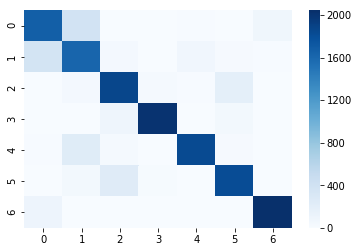

In [39]:
print(np.mean(scores))
sns.heatmap(confusion, cmap="Blues")

### with KNN & DT features

In [40]:
X_p = pd.concat([knn_train_df, dt_train_df, te_train_df], axis=1).astype(np.float32)
X_test_p = pd.concat([knn_test_df, dt_test_df, te_test_df.reset_index(drop=True)], axis=1).astype(np.float32)

#### RandomForestClassifier

In [41]:
KNNDT_RF_col = ["KNNDT_RF_{}_proba".format(i) for i in range(1, 8)]
for col in KNNDT_RF_col:
    train_level2.loc[:, col] = 0
    test_level2.loc[:, col] = 0

In [42]:
rfc = RandomForestClassifier(n_jobs=-1,
                             n_estimators=200,
                             max_depth=None,
                             max_features=.7,
                             max_leaf_nodes=220,
                             class_weight=class_weight)

confusion = np.zeros((7, 7))
scores = []
for train, val in tqdm(StratifiedKFold(n_splits=10, shuffle=True, random_state=2434).split(X_p, y)):
    X_train = X_p.iloc[train, :]
    y_train = y[train]
    X_val = X_p.iloc[val, :]
    y_val = y[val]
    rfc.fit(X_train, y_train)

    y_pred = rfc.predict(X_val)
    scores.append(balanced_accuracy_score(y_val, y_pred))
    confusion += confusion_matrix(y_val, y_pred)
    train_level2.loc[val, KNNDT_RF_col] = rfc.predict_proba(X_val)

rfc.fit(X_p, y)
test_level2.loc[:, KNNDT_RF_col] = rfc.predict_proba(X_test_p)

10it [13:13, 79.35s/it]


0.7590395721130895


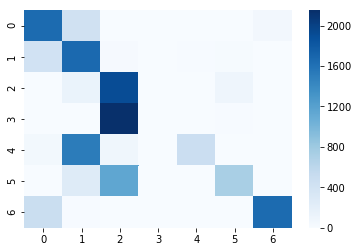

In [43]:
print(np.mean(scores))
sns.heatmap(confusion, cmap="Blues")

#### Logistic Regression

In [44]:
KNNDT_LR_col = ["KNNDT_LR_{}_proba".format(i) for i in range(1, 8)]
for col in KNNDT_LR_col:
    train_level2.loc[:, col] = 0
    test_level2.loc[:, col] = 0

In [45]:
confusion = np.zeros((7, 7))
scores = []
for train, val in tqdm(StratifiedKFold(n_splits=10, shuffle=True, random_state=2434).split(X, y)):
    X_train = X_p.iloc[train, :]
    y_train = y[train]
    X_val = X_p.iloc[val, :]
    y_val = y[val]
    lr = LogisticRegression(n_jobs=-1, multi_class="multinomial", C=10**9, solver="saga", class_weight=class_weight)
    lr.fit(X_train, y_train)
    y_val_pred = lr.predict(X_val)
    train_level2.loc[val, KNNDT_LR_col] = lr.predict_proba(X_val)
    scores.append(balanced_accuracy_score(y_val, y_val_pred))
    confusion += confusion_matrix(y_val, y_val_pred)

lr.fit(X_p, y)
test_level2.loc[:, KNNDT_LR_col] = lr.predict_proba(X_test_p)

10it [04:22, 26.30s/it]


0.7504927647829435


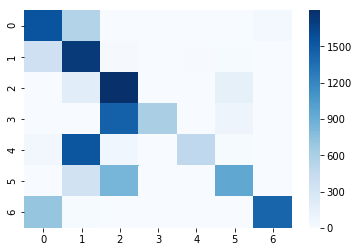

In [46]:
print(np.mean(scores))
sns.heatmap(confusion, cmap="Blues")

#### LightGBM

In [47]:
KNNDT_LGB_col = ["KNNDT_LGB_{}_proba".format(i) for i in range(1, 8)]
for col in KNNDT_LGB_col:
    train_level2.loc[:, col] = 0
    test_level2.loc[:, col] = 0

In [48]:
X = total_df[total_df["Id"] <= 15120].drop("Id", axis=1)
X_test = total_df[total_df["Id"] > 15120].drop("Id", axis=1).reset_index(drop=True)

X_d = pd.concat([X.drop(total_df.filter(regex="Type\d+").columns, axis=1),
                 knn_train_df,
                 dt_train_df], axis=1)

X_test_d = pd.concat([X_test.drop(total_df.filter(regex="Type\d+").columns, axis=1),
                 knn_test_df,
                 dt_test_df], axis=1)

fcol = X_d.select_dtypes(np.float64).columns
X_d.loc[:, fcol] = X_d.loc[:, fcol].astype(np.float32)
X_d = X_d.values.astype(np.float32)
X_test_d.loc[:, fcol] = X_test_d.loc[:, fcol].astype(np.float32)
X_test_d = X_test_d.values.astype(np.float32)

In [49]:
class_weight_lgbm = {i: v for i, v in enumerate(type_ratio)}

gbm = lgb.LGBMClassifier(n_estimators=300,
                         num_class=8,
                         num_leaves=32,
                         feature_fraction=0.3,
                         min_child_samples=20,
                         learning_rate=0.05,
                         num_boost_round=430,
                         max_depth=-1,                         
                         class_weight=class_weight_lgbm,
                         device="cpu",
                         n_jobs=4,
                         silent=-1,
                         verbose=-1)

confusion = np.zeros((7, 7))
scores = []
for train, val in tqdm(StratifiedKFold(n_splits=10, shuffle=True, random_state=2434).split(X_p, y)):
    X_train = X_d[train]
    X_val = X_d[val]

    y_train = y[train]
    y_val = y[val]
    gbm.fit(X_train, y_train, categorical_feature=[33, 42])

    y_pred = gbm.predict(X_val)
    scores.append(balanced_accuracy_score(y_val, y_pred))
    confusion += confusion_matrix(y_val, y_pred)
    train_level2.loc[val, KNNDT_LGB_col] = gbm.predict_proba(X_val)
    
gbm.fit(X_d, y, categorical_feature=[33, 42])
test_level2.loc[:, KNNDT_LGB_col] = gbm.predict_proba(X_test_d)

10it [05:40, 34.03s/it]


0.7689771387586072


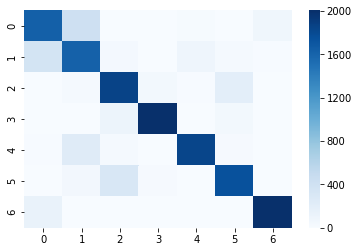

In [50]:
print(np.mean(scores))
sns.heatmap(confusion, cmap="Blues")

# ykskks's kernel

In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

#import warnings
#warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import lightgbm as lgb

['forest-cover-type-kernels-only']


In [52]:
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')

In [53]:
#drop columns that have the same value in every row
train.drop(['Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)
test.drop(['Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)

The feature enginnering ideas I used here are based on [Lathwal's amazing kernel ](https://www.kaggle.com/codename007/forest-cover-type-eda-baseline-model).

I removed 'slope_hyd' feature from the original one beacause it did'nt seem to be that useful for prediction.


In [54]:
train['HF1'] = train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Fire_Points']
train['HF2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Fire_Points'])
train['HR1'] = abs(train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Roadways'])
train['HR2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Roadways'])
train['FR1'] = abs(train['Horizontal_Distance_To_Fire_Points']+train['Horizontal_Distance_To_Roadways'])
train['FR2'] = abs(train['Horizontal_Distance_To_Fire_Points']-train['Horizontal_Distance_To_Roadways'])
train['ele_vert'] = train.Elevation-train.Vertical_Distance_To_Hydrology
train['Mean_Amenities']=(train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology + train.Horizontal_Distance_To_Roadways) / 3  
train['Mean_Fire_Hyd']=(train.Horizontal_Distance_To_Fire_Points + train.Horizontal_Distance_To_Hydrology) / 2 

In [55]:
test['HF1'] = test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points']
test['HF2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])
test['HR1'] = abs(test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])
test['HR2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])
test['FR1'] = abs(test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])
test['FR2'] = abs(test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])
test['ele_vert'] = test.Elevation-test.Vertical_Distance_To_Hydrology 
test['Mean_Amenities']=(test.Horizontal_Distance_To_Fire_Points + test.Horizontal_Distance_To_Hydrology + test.Horizontal_Distance_To_Roadways) / 3  
test['Mean_Fire_Hyd']=(test.Horizontal_Distance_To_Fire_Points + test.Horizontal_Distance_To_Hydrology) / 2

In [56]:
#Id for later use
Id_train=train['Id']
Id_test=test['Id']

train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [57]:
x_train=train.drop('Cover_Type', axis=1)
y_train=train['Cover_Type']

## randomforest

In [58]:
#prepare df to store pred proba
x_train_L2=pd.DataFrame(Id_train)
x_test_L2=pd.DataFrame(Id_test)
rf_cul=['rf'+str(i+1) for i in range(7)]

#prepare cols to store pred proba
for i in rf_cul:
    x_train_L2.loc[:, i]=0
    x_test_L2.loc[:, i]=0

rf=RandomForestClassifier(max_depth=None, max_features=20,n_estimators=500, random_state=1)

#StratifiedKfold to avoid leakage
for train_index, val_index in tqdm(StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(x_train, y_train)):
    x_train_L1=x_train.iloc[train_index, :]
    y_train_L1=y_train.iloc[train_index]
    x_val_L1=x_train.iloc[val_index, :]
    y_val_L1=y_train.iloc[val_index]

    rf.fit(x_train_L1, y_train_L1)
    y_val_proba=rf.predict_proba(x_val_L1)
    x_train_L2.loc[val_index, rf_cul]=y_val_proba

rf.fit(x_train, y_train)
x_test_L2.loc[:, rf_cul]=rf.predict_proba(test)

#prepare df for submission
#submit_df=pd.DataFrame(rf.predict(test))
#submit_df.columns=['Cover_Type']
#submit_df['Id']=Id_test
#submit_df=submit_df.loc[:, ['Id', 'Cover_Type']]
#submit_df.to_csv('rf.csv', index=False)

#0.75604

10it [06:41, 40.12s/it]


## LightGBM

In [59]:
#prepare df to store pred proba
#x_train_L2=pd.DataFrame(Id_train)
#x_test_L2=pd.DataFrame(Id_test)
lgbm_cul=['lgbm'+str(i+1) for i in range(7)]

#prepare cols to store pred proba
for i in lgbm_cul:
    x_train_L2.loc[:, i]=0
    x_test_L2.loc[:, i]=0

lgbm=lgb.LGBMClassifier(learning_rate=0.3, max_depth=-1, min_child_samples=20, n_estimators=300, num_leaves=200, random_state=1, n_jobs=4)

#StratifiedKfold to avoid leakage
for train_index, val_index in tqdm(StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(x_train, y_train)):
    x_train_L1=x_train.iloc[train_index, :]
    y_train_L1=y_train.iloc[train_index]
    x_val_L1=x_train.iloc[val_index, :]
    y_val_L1=y_train.iloc[val_index]

    lgbm.fit(x_train_L1, y_train_L1)
    y_val_proba=lgbm.predict_proba(x_val_L1)
    x_train_L2.loc[val_index, lgbm_cul]=y_val_proba

lgbm.fit(x_train, y_train)
x_test_L2.loc[:, lgbm_cul]=lgbm.predict_proba(test)

#prepare df for submission
#submit_df=pd.DataFrame(lgbm.predict(test))
#submit_df.columns=['Cover_Type']
#submit_df['Id']=Id_test
#submit_df=submit_df.loc[:, ['Id', 'Cover_Type']]
#submit_df.to_csv('lgbm.csv', index=False)

10it [02:19, 13.98s/it]


## LR

In [60]:
lr_cul=['lr'+str(i+1) for i in range(7)]

#prepare cols to store pred proba
for i in lr_cul:
    x_train_L2.loc[:, i]=0
    x_test_L2.loc[:, i]=0
    
pca=PCA(n_components=40)
x_train_pca=pd.DataFrame(pca.fit_transform(x_train))
test_pca=pd.DataFrame(pca.transform(test))

pipeline=Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(C=10, solver='newton-cg', multi_class='multinomial',max_iter=500))])

#StratifiedKfold to avoid leakage
for train_index, val_index in tqdm(StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(x_train_pca, y_train)):
    x_train_L1=x_train_pca.iloc[train_index, :]
    y_train_L1=y_train.iloc[train_index]
    x_val_L1=x_train_pca.iloc[val_index, :]
    y_val_L1=y_train.iloc[val_index]

    pipeline.fit(x_train_L1, y_train_L1)
    y_val_proba=pipeline.predict_proba(x_val_L1)
    x_train_L2.loc[val_index, lr_cul]=y_val_proba

pipeline.fit(x_train_pca, y_train)
x_test_L2.loc[:, lr_cul]=pipeline.predict_proba(test_pca)

#prepare df for submission
#submit_df=pd.DataFrame(pipeline.predict(test_pca))
#submit_df.columns=['Cover_Type']
#submit_df['Id']=Id_test
#submit_df=submit_df.loc[:, ['Id', 'Cover_Type']]
#submit_df.to_csv('lr.csv', index=False)

10it [01:08,  6.88s/it]


## SVM

In [61]:
svm_cul=['svm'+str(i+1) for i in range(7)]

#prepare cols to store pred proba
for i in svm_cul:
    x_train_L2.loc[:, i]=0
    x_test_L2.loc[:, i]=0
    
#pca=PCA(n_components=40)
#x_train_pca=pca.fit_transform(x_train)
#test_pca=pca.transform(test)

pipeline=Pipeline([('scaler', StandardScaler()), ('svm', SVC(C=10, gamma=0.1, probability=True))])


#StratifiedKfold to avoid leakage
for train_index, val_index in tqdm(StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(x_train_pca, y_train)):
    x_train_L1=x_train_pca.iloc[train_index, :]
    y_train_L1=y_train.iloc[train_index]
    x_val_L1=x_train_pca.iloc[val_index, :]
    y_val_L1=y_train.iloc[val_index]

    pipeline.fit(x_train_L1, y_train_L1)
    y_val_proba=pipeline.predict_proba(x_val_L1)
    x_train_L2.loc[val_index, svm_cul]=y_val_proba

pipeline.fit(x_train_pca, y_train)
x_test_L2.loc[:, svm_cul]=pipeline.predict_proba(test_pca)

#prepare df for submission
#submit_df=pd.DataFrame(pipeline.predict(test_pca))
#submit_df.columns=['Cover_Type']
#submit_df['Id']=Id_test
#submit_df=submit_df.loc[:, ['Id', 'Cover_Type']]
#submit_df.to_csv('svm.csv', index=False)

10it [09:53, 59.38s/it]


# stacking

## Level1 summary

In [62]:
# concatenate two data
train_L2 = pd.concat([x_train_L2.iloc[:, 1:].reset_index(drop=True), train_level2.iloc[:, 1:].reset_index(drop=True)], axis=1)
test_L2 = pd.concat([x_test_L2.iloc[:, 1:].reset_index(drop=True), test_level2.iloc[:, 1:].reset_index(drop=True)], axis=1)
train_L2.to_csv("Wtrain_L2.csv", index=False)
test_L2.to_csv("Wtest_L2.csv", index=False)

KNNDT_LGB_1_proba	0.76898
KNNDT_LR_1_proba	0.75049
KNNDT_RF_1_proba	0.75904
LGBM1_1_proba	0.7778
KNN1_1_proba	0.63901
RFC1_1_proba	0.75007
svm1	0.75199
lr1	0.60981
lgbm1	0.79033
rf1	0.78533


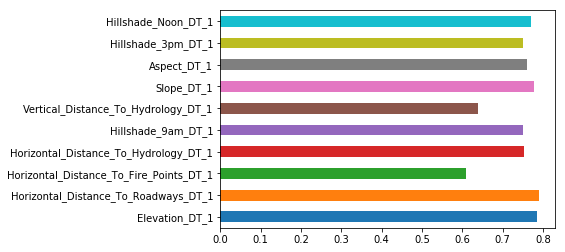

In [63]:
# each models score

y = pd.read_csv("./train.csv")["Cover_Type"].values
model_scores = {}
text = []

for i in range(10):
    y_pred = np.argmax(train_L2.iloc[:, 7*i:7*(i+1)].values, axis=1) + 1
    score = balanced_accuracy_score(y, y_pred)
    model_scores[cols[i*7]] = score
    text.append("{}\t{:<.5}".format(train_L2.columns[i*7], score))

print(*text[::-1], sep="\n")
pd.Series(model_scores).plot(kind="barh")
plt.savefig("model_summary.png")

## stacking with Logistic Regression

### nadare's simple stacking

In [64]:
score = []
for train, val in tqdm(StratifiedKFold(n_splits=10, random_state=2434, shuffle=True).split(X, y)):
    X_train = train_level2.iloc[train, 1:]
    X_val = train_level2.iloc[val, 1:]
    y_train = y[train]
    y_val = y[val]
    lr = LogisticRegression(n_jobs=1, class_weight=class_weight)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    score.append(balanced_accuracy_score(y_val, y_pred))
    #print(score[-1])
print(np.mean(score))

10it [00:07,  1.34it/s]

0.7914620262681955


### ykskks's simple stacking

In [65]:
score = []
for train, val in tqdm(StratifiedKFold(n_splits=10, random_state=2434, shuffle=True).split(X, y)):
    X_train = x_train_L2.iloc[train, 1:]
    X_val = x_train_L2.iloc[val, 1:]
    y_train = y[train]
    y_val = y[val]
    lr = LogisticRegression(n_jobs=1, class_weight=class_weight)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    score.append(balanced_accuracy_score(y_val, y_pred))
print(np.mean(score))

lr = LogisticRegression(n_jobs=1, class_weight=class_weight)
lr.fit(x_train_L2, y)


10it [00:05,  1.78it/s]


0.8270026295233303


LogisticRegression(C=1.0,
          class_weight={1: 0.37053, 2: 0.49681, 3: 0.05936, 4: 0.00103, 5: 0.01295, 6: 0.02687, 7: 0.03242},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='warn', n_jobs=1, penalty='l2',
          random_state=None, solver='warn', tol=0.0001, verbose=0,
          warm_start=False)

### double simple stacking

In [66]:
score = []
for train, val in tqdm(StratifiedKFold(n_splits=10, random_state=2434, shuffle=True).split(X, y)):
    X_train = train_L2.iloc[train, 1:]
    X_val = train_L2.iloc[val, 1:]
    y_train = y[train]
    y_val = y[val]
    lr = LogisticRegression(n_jobs=1, class_weight=class_weight)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    score.append(balanced_accuracy_score(y_val, y_pred))
print(np.mean(score))

10it [00:13,  1.36s/it]

0.8307150140430138


In [67]:
# this is 0.83266 on public LB
"""
smpsb = pd.read_csv("./sample_submission.csv")
lr = LogisticRegression(n_jobs=1, class_weight=class_weight)
lr.fit(train_L2, y)
smpsb["Cover_Type"] = lr.predict(test_L2)
smpsb.to_csv("W_ensemble_LR.csv", index=False)"""

'\nsmpsb = pd.read_csv("./sample_submission.csv")\nlr = LogisticRegression(n_jobs=1, class_weight=class_weight)\nlr.fit(train_L2, y)\nsmpsb["Cover_Type"] = lr.predict(test_L2)\nsmpsb.to_csv("W_ensemble_LR.csv", index=False)'

## stacking with LightGBM

In [68]:
wtrain = train_L2.values.astype(np.float32)
wtest = test_L2.values.astype(np.float32)
y = pd.read_csv("./train.csv")["Cover_Type"].values
smpsb = pd.read_csv("./sample_submission.csv")
cols = train_L2.columns

In [69]:
# this is our final submission which is 0.84806 on Public LB
gbm = lgb.LGBMClassifier(n_estimators=300,
                         num_class=8,
                         num_leaves=25,
                         learning_rate=5,
                         min_child_samples=20,
                         bagging_fraction=.3,
                         bagging_freq=1,
                         reg_lambda = 10**4.5,
                         reg_alpha = 1,
                         feature_fraction=.2,
                         num_boost_round=4000,
                         max_depth=-1,
                         class_weight=class_weight_lgbm,
                         device="cpu",
                         n_jobs=4,
                         silent=-1,
                         verbose=-1)

gbm.fit(wtrain, y, verbose=-1)
smpsb["Cover_Type"] = gbm.predict(wtest)
smpsb.to_csv("final_submission.csv", index=False)

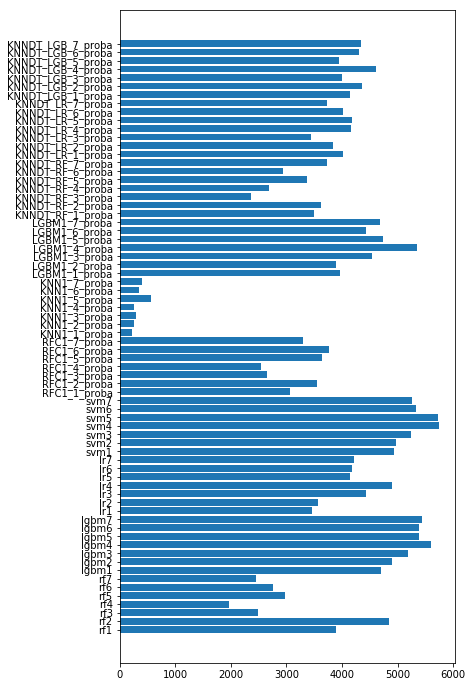

In [70]:
plt.figure(figsize=(6, 12))
plt.barh(cols, gbm.feature_importances_)
plt.savefig("feature_importances.png")

In [71]:
# bagging with k-fold
scores = []
gbm = lgb.LGBMClassifier(n_estimators=300,
                         num_class=8,
                         num_leaves=25,
                         learning_rate=5,
                         min_child_samples=20,
                         bagging_fraction=.3,
                         bagging_freq=1,
                         reg_lambda = 10**4.5,
                         reg_alpha = 1,
                         feature_fraction=.2,
                         num_boost_round=8000,
                         max_depth=-1,
                         class_weight=class_weight_lgbm,
                         device="cpu",
                         n_jobs=-1,
                         silent=-1,
                         verbose=-1)

proba = np.zeros((wtest.shape[0], 7))
for train, val in tqdm(StratifiedKFold(n_splits=5, shuffle=True, random_state=2434).split(wtrain, y)):
    X_train = wtrain[train]
    X_val = wtrain[val]
    y_train = y[train]
    y_val = y[val]
    gbm.fit(X_train, y_train, verbose=-1, 
            eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=20)
    proba += gbm.predict_proba(wtest) / 10
    y_pred = gbm.predict(X_val)
    scores.append(balanced_accuracy_score(y_val, y_pred))

print(np.mean(scores))

0it [00:00, ?it/s]

Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[5281]	valid_0's multi_logloss: 0.561351	valid_1's multi_logloss: 0.603086


1it [13:05, 785.82s/it]

Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[3730]	valid_0's multi_logloss: 0.597576	valid_1's multi_logloss: 0.640298


2it [22:04, 662.01s/it]

Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[4495]	valid_0's multi_logloss: 0.581384	valid_1's multi_logloss: 0.617698


3it [33:11, 663.88s/it]

Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[4510]	valid_0's multi_logloss: 0.580649	valid_1's multi_logloss: 0.630832


4it [43:22, 650.56s/it]

Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[4965]	valid_0's multi_logloss: 0.57419	valid_1's multi_logloss: 0.620713


5it [56:38, 679.70s/it]

0.8455668160785565


In [72]:
smpsb["Cover_Type"] = np.argmax(proba, axis=1) + 1
smpsb.to_csv("submission.csv", index=False)